<a href="https://colab.research.google.com/github/MuhammadAwon/backyard-projects/blob/main/intro-to-deep-learning/transfer_learning_feature_extraction/TF_Hub_Retraining_an_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retraining an Image Classifier

## Introduction

Image classification models have millions of parameters. Training them from scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TFLite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://www.tensorflow.org/lite/tutorials/model_maker_image_classification) TFLite colab.

## Setup

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print('TF version:', tf.__version__)
print('Hub version:', hub.__version__)
print('GPU is', 'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE')

TF version: 2.7.0
Hub version: 0.12.0
GPU is available


## Select the TF2 SavedModel module to use

For starters, use
https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4. The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 model that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [ ]:
model_name = "efficientnetv2-b0"  # @param ['efficientnetv2-b0', 'inception_v3', 'nasnet_large', 'pnasnet_large']

model_handle_map = {  
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
}

model_image_size_map = {
    "efficientnetv2-b0": 224,
    "inception_v3": 229,
    "nasnet_large": 331,
    "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 331)  # pixels value changes with model selection respectively

print(f'Selected model: {model_name} : {model_handle}')

IMG_SIZE = (pixels, pixels)
print(f'Input size {IMG_SIZE}')

BATCH_SIZE = 16

Selected model: efficientnetv2-b0 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Input size (224, 224)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) imporves training, esp. when fine-tuning.

In [ ]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [ ]:
def build_dataset(subset):
  dataset = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode='categorical',
      # Seed needs to be provided when using validation_split and shuffle=True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=42,
      image_size=IMG_SIZE,
      batch_size=1)
  return dataset

In [ ]:
# Create training dataset
train_ds = build_dataset('training')
# Get class names
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False  # @param {type: "boolean"}
if do_data_augmentation:
  preprocessing_model.add(tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(tf.keras.layers.RandomFlip(mode='horizontal'))

# Map preprocessing_model with train dataset
train_ds = train_ds.map(lambda images, labels: (preprocessing_model(images), labels))

In [ ]:
# Create validation dataset
val_ds = build_dataset('validation')
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

# Map preprocessing_model with validation dataset
val_ds = val_ds.map(lambda images, labels: (preprocessing_model(images), labels))

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [ ]:
do_fine_tuning = False  # @param {type: "boolean"}

In [ ]:
print('Building model with', model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.build((None,)+IMG_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 5,925,717
Trainable params: 6,405
Non-trainable params: 5,919,312
_________________________________________________________________


## Training the model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy']
)

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size//BATCH_SIZE
hist = model.fit(train_ds,
                 epochs=5,
                 steps_per_epoch=steps_per_epoch,
                 validation_data=val_ds,
                 validation_steps=validation_steps).history

Epoch 1/5
183/183 [==============================] - 26s 98ms/step - loss: 0.8379 - accuracy: 0.7852 - val_loss: 0.7194 - val_accuracy: 0.8556
Epoch 2/5
183/183 [==============================] - 15s 79ms/step - loss: 0.6671 - accuracy: 0.8911 - val_loss: 0.6830 - val_accuracy: 0.8708
Epoch 3/5
183/183 [==============================] - 15s 79ms/step - loss: 0.6389 - accuracy: 0.8990 - val_loss: 0.6706 - val_accuracy: 0.8778
Epoch 4/5
183/183 [==============================] - 15s 79ms/step - loss: 0.6138 - accuracy: 0.9185 - val_loss: 0.6560 - val_accuracy: 0.8875
Epoch 5/5
183/183 [==============================] - 17s 93ms/step - loss: 0.6000 - accuracy: 0.9271 - val_loss: 0.6431 - val_accuracy: 0.8958


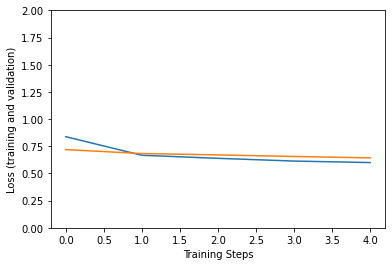

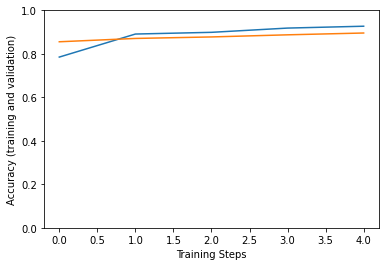

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"]);

Try out the model on an image from the validation data:

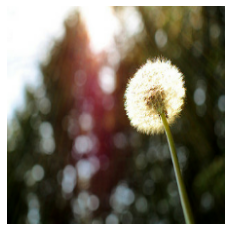

True label: dandelion
Predicted label: dandelion


In [ ]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
predicting_scores = model.predict(tf.expand_dims(image, axis=0))
predicted_index = np.argmax(predicting_scores)
print('True label: ' + class_names[true_index])
print('Predicted label: ' + class_names[predicted_index])

Finally, the trained model can be saved for deployment to TF Serving or TFLite (on mobile) as follows.

In [ ]:
saved_model_path = f"saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: saved_flowers_model_efficientnetv2-b0/assets


INFO:tensorflow:Assets written to: saved_flowers_model_efficientnetv2-b0/assets


## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TFLite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TFLite Interpreter to examine the resulting quality
 * Converting without optimization provides the same results as before (up to roundoff error).
 * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network actiavtions. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
 * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like Edge TPU.

### Optimization settings


In [ ]:
# @title Optimization settings
optimize_lite_model = False  # @param {type: "boolean"}
# @markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  # @param {type: "slider", min: 0, max: 1000, step: 1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_example)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f'lite_flowers_model_{model_name}.tflite', 'wb') as f:
  f.write(lite_model_content)
print('Wrote %sTFLite model of %d bytes.' %
      ('optimized ' if optimize_lite_model else '', len(lite_model_content)))

Wrote TFLite model of 23422996 bytes.


In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
# @markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  # @param {type: "slider", min: 0, max: 700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print('TFLite model agrees with original model on %d of %d examples (%g%%).' %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print('TFLite model is accurate on %d of %d examples (%g%%).' %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TFLite model agrees with original model on 50 of 50 examples (100%).
TFLite model is accurate on 47 of 50 examples (94%).
